In [1]:
import pandas as pd
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from CustomTransformers import *
from Evaluation import *
from FeatureExtraction import *

In [2]:
train = pd.read_json("../data/training.json")
test = pd.read_json("../data/test.json")

train_features = train.drop('label', axis=1)
train_target = train['label']

test_features = test.drop('label', axis=1)
test_target = test['label']

In [3]:
train.head()

,create_time,from_id,from_user,hashtag,label,location,mention,term,tweet_id
0,2013-10-07 17:46:10,1042956938,_kayxchi,empty_hashtag,0,empty_location,TheRealKhaa__,my hair not messed up but this umbrella keep b...,387212256515469312
1,2013-07-13 02:16:11,340590272,HighImCoreyy,empty_hashtag,0,empty_location,trentxsweat,wtf you ass,355812862075224064
10,2014-06-08 10:49:18,1576430503,emiliee171,empty_hashtag,0,empty_location,FIirtationship,rt if i get mad at you that means i still care...,475529987781447680
100,2014-01-06 02:27:00,2270482320,TodoSismos,Earthquake Sismo,1,loc_argentina,empty_mention,m 10 6km nw of the geysers california time2014...,419943136907898880
1000,2014-01-21 06:00:32,377627543,_heyitsmadison_,empty_hashtag,0,loc_city_of_brotherly_love,comedyandtruth,when a girl says im fine,425432692306350080


Set up a pipeline for training a classifier based on the training data. Vectorize each of the five main feature columns (Term, Hashtag, From_id, Location, Mention) and create a single feature vector with FeatureUnion.
The classifier is a Logistic Regression with Cross validation which currently is set up under the default configuration.

In [35]:
pipeline = Pipeline([
    ('features', FeatureUnion(
            transformer_list=[
                ('term', Pipeline([
                    ('selector', ItemSelector(key='term')),
                    ('tfidf', TfidfVectorizer()),
                ])),
                
                ('hashtag', Pipeline([
                    ('selector', ItemSelector(key='hashtag')),
                    ('count', HashtagCountVectorizer()),
                ])),
                
                ('user', Pipeline([
                    ('selector', ItemSelector(key='from_user')),
                    ('count', CountVectorizer()),
                ])),
                
                ('location', Pipeline([
                    ('selector', ItemSelector(key='location')),
                    ('count', CountVectorizer()),
                ])),
                
                ('mention', Pipeline([
                    ('selector', ItemSelector(key='mention')),
                    ('count', CountVectorizer()),
                ]))
               
            ])),
    
    ('classifier', LogisticRegressionCV())
    
])

In [36]:
pipeline.fit(train_features, train_target)

predictions = pipeline.predict_proba(test_features)[:, 1]

In [37]:
print_evaluation_summary(test_target, predictions, 100)

Precision@100 = 0.988636363636 
Recall@100 = 0.956043956044
AveP = 0.720796127248


In [38]:
pipeline2 = Pipeline([
    ('features', FeatureUnion(
            transformer_list=[
                ('term', Pipeline([
                    ('selector', ItemSelector(key='term')),
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                ])),
                
                ('hashtag', Pipeline([
                    ('selector', ItemSelector(key='hashtag')),
                    ('count', HashtagCountVectorizer()),
                ])),
            ])),
    
    ('classifier', LogisticRegressionCV())    
])

In [39]:
pipeline2.fit(train_features, train_target)

predictions2 = pipeline2.predict_proba(test_features)[:, 1]

In [40]:
print_evaluation_summary(test_target, predictions2, 100)

Precision@100 = 1.0 
Recall@100 = 1.0
AveP = 0.890138539021


In [41]:
top_features_by_kind(pipeline, [100, 50, 20, 20])

([u'#prayforthephilippines',
  u'#earthquake',
  u'#storm',
  u'#tornado',
  u'#ukstorm',
  u'#haiyan',
  u'#flood',
  u'#sandy',
  u'#hurricane',
  u'#drought',
  u'#arthur',
  u'#eqnz',
  u'#hurricanes',
  u'#quake',
  u'#typhoon',
  u'#serbiafloods',
  u'#napaquake',
  u'#prayforchile',
  u'#earthquakeph',
  u'#tsunami',
  u'#phailin',
  u'#laearthquake',
  u'#typhoonhaiyan',
  u'#hurricanearthur',
  u'#cholera',
  u'#katrina',
  u'#bertha',
  u'#hurricanesandy',
  u'#ukfloods',
  u'#hurricanekatrina',
  u'#napaearthquake',
  u'#hurricanenation',
  u'#manuel',
  u'#laquake',
  u'#quakecon2014',
  u'#quakelive',
  u'#quakecon',
  u'#typhoonaid',
  u'#tsunamimarch',
  u'hurricane',
  u'#hurricanekid',
  u'#anc',
  u'yrs',
  u'#bosniafloods',
  u'#typhoonyolanda',
  u'#hurricaneseason',
  u'#corkfloods',
  u'#reddeer',
  u'#abfloods',
  u'#hurricaneprep',
  u'help',
  u'#kashmirfloods',
  u'#re',
  u'philippines',
  u'safe',
  u'eso',
  u'#hurricanebertha',
  u'storm',
  u'#typhoonmari

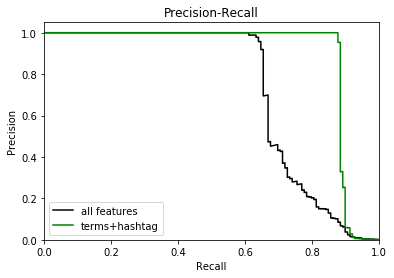

In [53]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(test_target, predictions)
precision2, recall2, _ = precision_recall_curve(test_target, predictions2)

pr1 = plt.plot(recall, precision, color='black', label="all features")
pr2 = plt.plot(recall2, precision2, color='g', label="terms+hashtag")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.show()